SNR:  4.351054551478331
Mean Squared Error:  0.1952860946160476


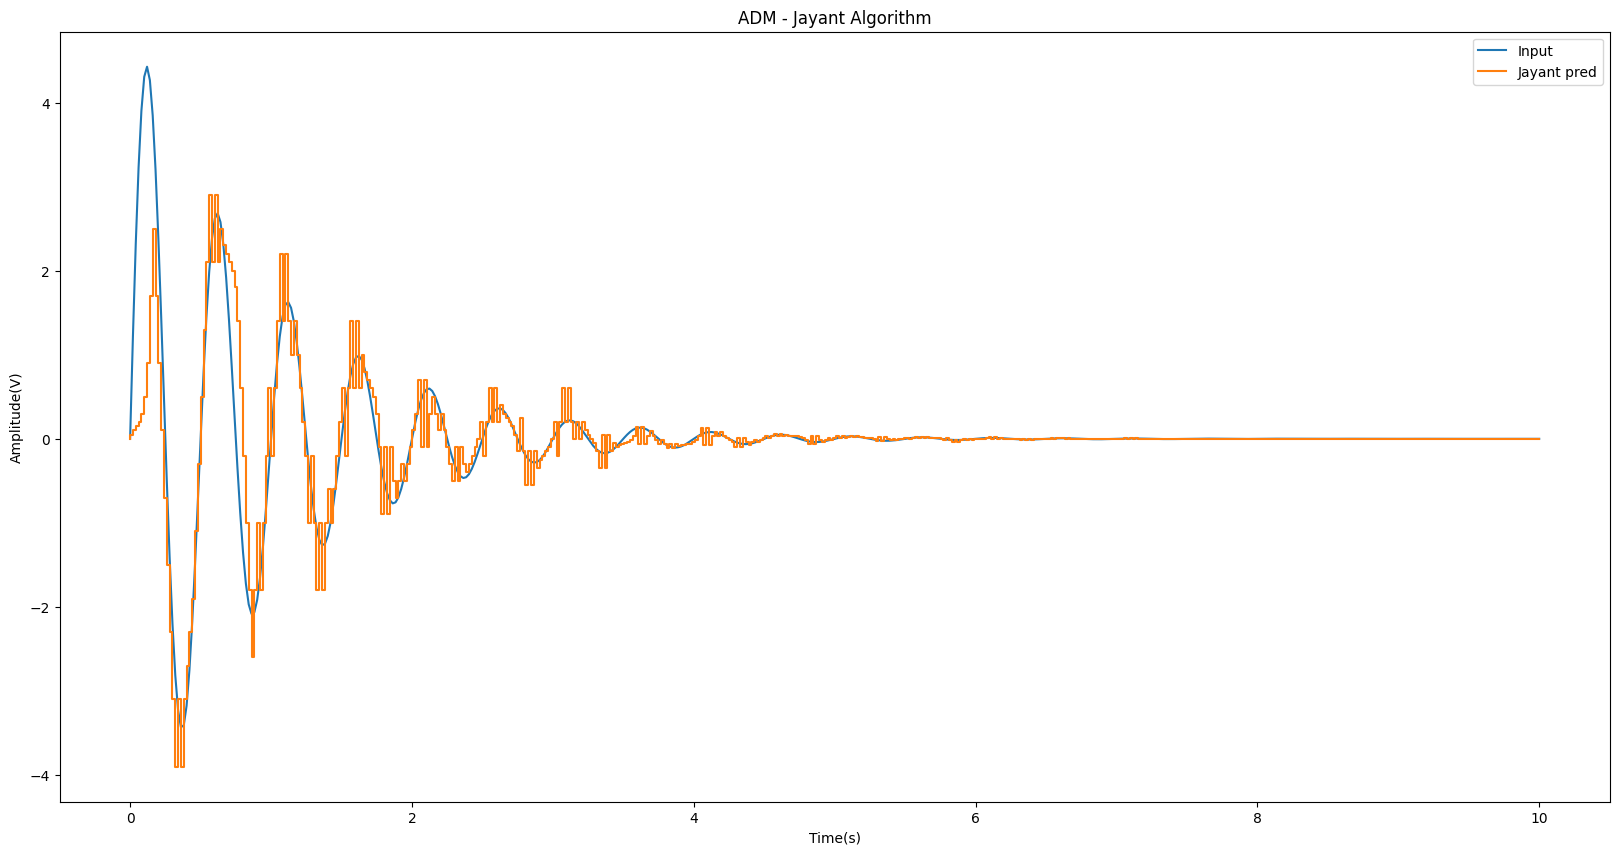

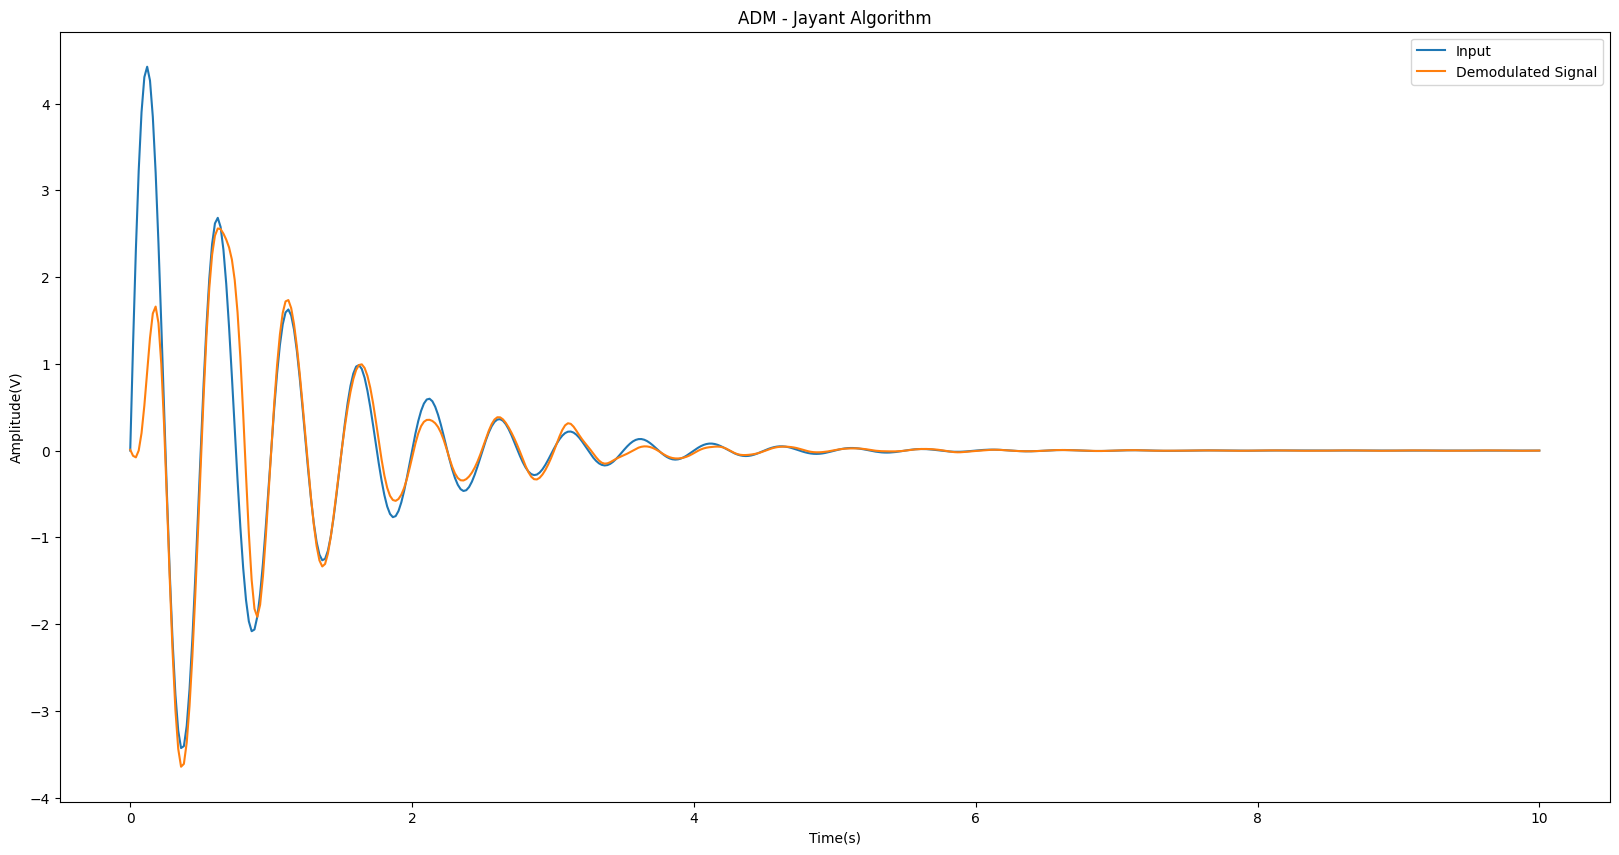

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def jayant_adm_modulator(x):
    N = len(x)
    y = np.zeros(N) # Array for encoded error signal
    y = y.astype(int) # To convert elements in the array to integers
    pred = np.zeros(N)

    delta = 0.05
    max_delta = delta * 16 # We are limiting delta so that it dosent go too high or low
    min_delta = delta / 16

    curr = 0
    for i in range(1, N):
        if i > 4:
          # If there is a series of 0000 or 1111 (in the encoded error signal) we increse delta by 2 times to decrease slope overload error
            if not (y[i-3] ^ y[i-4]) and not (y[i-3] ^ y[i-2]) and not (y[i-2] ^ y[i-1]): # ^ means xor
                if delta < max_delta:
                    delta *= 2
            # If there is a series of 0101 or 1010 (in the encoded error signal) we decrease delta by 2 times to decrease granular error
            elif (y[i-3] ^ y[i-4]) and (y[i-3] ^ y[i-2]) and (y[i-2] ^ y[i-1]):
                if delta > min_delta:
                    delta /= 2

        if x[i] >= curr: # If signal sample> current predicted value(x hat(n)), then new predicted value inc by delta
            y[i] = 1 # We assign value to ith bit in encoded signal
            curr += delta
        else:
            y[i] = 0
            curr -= delta

        if y[i] == 0:
            err = -1
        else:
            err = 1
        pred[i] = pred[i-1] + err*delta #updating pred matrix

    return y, pred

def jayant_adm_demodulator(y, f, Fs):
    N = 500
    z = np.zeros(N)

    delta = 0.05
    max_delta = delta * 16
    min_delta = delta / 16

    for i in range(1, N):
        if i > 4:
            if not (y[i-3] ^ y[i-4]) and not (y[i-3] ^ y[i-2]) and not (y[i-2] ^ y[i-1]):
                if delta < max_delta:
                    delta *= 2
            elif (y[i-3] ^ y[i-4]) and (y[i-3] ^ y[i-2]) and (y[i-2] ^ y[i-1]):
                if delta > min_delta:
                    delta /= 2
        # Adding Step size to the predicted output
        if y[i] == 1:
            z[i] = z[i-1] + delta
        else:
            z[i] = z[i-1] - delta

    fs = 1000 # Sampling rate (Hz)
    fc = 100 # Cutoff frequency (Hz)
    order = 4 # Filter order

    # Calculate filter coefficients using a Butterworth filter
    b, a = butter(order, fc / (fs / 2), 'low')

   # Apply the filter to the signal
    z = filtfilt(b, a, z)

    return z

def isnr(x, y):
    # Calculate Signal-to-Noise Ratio (SNR) in dB
    noise = x - y
    mse = np.mean(np.square(noise))
    return 10 * np.log10(np.mean(np.square(x))/mse)

# Create signal
length = 500
t = np.linspace(0, 10, length)
Fs = 50
amp = 5
f = 2.0
x1 = amp * np.sin(2*np.pi*f*t) * np.exp(-t)

# Modulation
jayant_out, jayant_pred = jayant_adm_modulator(x1)

# Demodulation
jayant_demod = jayant_adm_demodulator(jayant_out, f, Fs)

dm_pred_snr1 = isnr(x1, jayant_pred)
dm_demod_mse1 = np.mean(np.square(x1 - jayant_demod))
print("SNR: ",dm_pred_snr1)
print("Mean Squared Error: ",dm_demod_mse1)

# Plot results
fig = plt.figure(figsize=(20, 10))
plt.plot(t, x1)
plt.step(t, jayant_pred)
plt.title('ADM - Jayant Algorithm')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude(V)')
plt.legend(['Input', 'Jayant pred'])

fig2 = plt.figure(figsize=(20, 10))
plt.plot(t, x1)
plt.plot(t, jayant_demod)
plt.title('ADM - Jayant Algorithm')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude(V)')
plt.legend(['Input', 'Demodulated Signal'])

plt.show()